In [3]:
# Imports 

import numpy as np
import glob
import csv
import osb
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.io import wavfile

plt.style.use('ggplot')

In [60]:
# Functions for accessing length of sequences in WAVE files
def get_recording_lengths(ddir):
    filenames = glob.glob(os.path.join(ddir, '*wav'))
    seq_lengths = np.zeros(len(filenames))
    
    for i, fn in enumerate(filenames):
        _, data = wavfile.read(fn)
        seq_lengths[i] = data.shape[0]
        
    return seq_lengths


def get_training_recording_lengths(training_ddir):
    train_sub_ddir = glob.glob(os.path.join(training_ddir, '*'))

    for i, tsd in enumerate(train_sub_ddir):
        if i == 0:
            seq_lengths = get_recording_lengths(tsd)
        else:
            seq_lengths = np.concatenate([seq_lengths, get_recording_lengths(tsd)])
        
    return seq_lengths
    

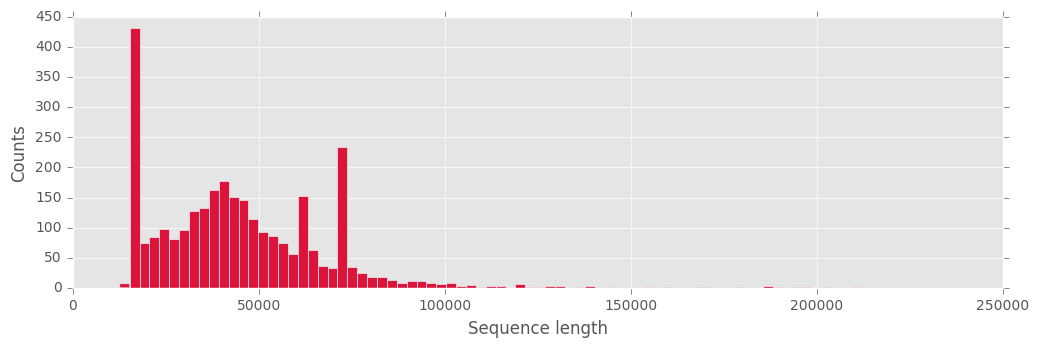

In [75]:
# Plot histogram of sequence lengths
seq_lengths = get_training_recording_lengths('data/raw/training')
plt.xlabel('Sequence length')
plt.ylabel('Counts')
plt.hist(seq_lengths, bins=75, color='crimson')

f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(3.5)

plt.show()

In [ ]:
# Functions for generating sequences from WAVE files

def gen_sequences(in_ddir, out_ddir):
    
    if not os.path.exists(out_ddir):
        os.mkdir(out_ddir)
        
    if not os.path.exists(out_ddir + '/full'):
        os.makedirs(out_ddir + '/full')
        
    if not os.path.exists(out_ddir + '/sub'):
        os.makedirs(out_ddir + '/sub')
        
    filenames = glob.glob(os.path.join(in_ddir, '*wav'))
    for fn in filenames:
        rate, data = wavfile.read(fn)
                
        # Generate subsequences
        subseqs = gen_subsequences(5.0, data, 10000)

        # Save sequence and subsequence arrays
        fn_prefix = fn.split('.')[0].split('/')[-1]
        np.save(os.path.join(out_ddir + '/full', fn_prefix), data)
        for i, s in enumerate(subseqs):
            np.save(os.path.join(out_ddir + '/sub', fn_prefix + '_' + str(i)), s)

    
def gen_subsequences(subseq_size, seq, max_len):

    time = np.arange(len(data)) / rate
    
    num_windows = (time[-1] // subseq_size).astype(np.int32)

    window_indices = np.zeros(num_windows)
    for n in range(num_windows):
        window_indices[n] = np.where(time < subseq_size * (n + 1))[0][-1]

    subseqs = np.split(data, window_indices + 1)

    if subseqs[-2].shape[0] - subseqs[-1].shape[0] > 1:
        subseqs = subseqs[:-1]

    for i, s in enumerate(subseqs):
        while s.shape[0] < max_len:
            s = np.insert(s, obj=s.shape[0], values=0)
        subseqs[i] = s
        
    return subseqs

def gen_training_sequences(training_ddir, out_ddir):
    train_sub_ddir = glob.glob(os.path.join(training_ddir, '*'))
    for tsd in train_sub_ddir:
        gen_sequences(tsd, out_ddir)
    

In [2]:
# Functions for generating spectrograms from WAVE files

def gen_spectrograms(in_ddir, out_ddir):
    
    if not os.path.exists(out_ddir):
        os.mkdir(out_ddir)
        
    if not os.path.exists(out_ddir + '/full'):
        os.makedirs(out_ddir + '/full')
        
    if not os.path.exists(out_ddir + '/sub'):
        os.makedirs(out_ddir + '/sub')
        
    filenames = glob.glob(os.path.join(in_ddir, '*wav'))
    for fn in filenames:
        rate, data = wavfile.read(fn)
        
        # Generate spectrogram
        Pxx, freqs, bins, im = plt.specgram(data, NFFT=300, Fs=rate, 
                                            mode='psd', noverlap=200, scale='dB',
                                            xextent=(0,np.floor(data.shape[0]/rate)))
        
        # Rescale to decibel
        #Pxx_dcb = 10 * np.log10(Pxx)
        Pxx_dcb = Pxx
        
        # Generate supspectra
        subspecs = gen_subspecs(5.0, Pxx_dcb, bins, 100)

        # Save spectrogram and subspectra arrays
        fn_prefix = fn.split('.')[0].split('/')[-1]
        np.save(os.path.join(out_ddir + '/spec', fn_prefix), Pxx_dcb)
        for i, s in enumerate(subspecs):
            np.save(os.path.join(out_ddir + '/subspec', fn_prefix + '_' + str(i)), s)
        
        # Generate and save spectrogram plot
        #f = plt.gcf()
        #f.set_figwidth(12)
        #f.set_figheight(3.5)
        
        #plt.savefig(os.path.join(out_ddir + '/spect', fn_prefix + '.png'), 
        #            format='png')
        

def gen_training_spectrograms(training_ddir, out_ddir):
    train_sub_ddir = glob.glob(os.path.join(training_ddir, '*'))
    for tsd in train_sub_ddir:
        gen_spectrograms(tsd, out_ddir)
        

def gen_subspecs(subspec_size, Pxx, bins, max_len):
    
    num_windows = (bins[-1] // subspec_size).astype(np.int32)

    window_indices = np.zeros(num_windows)
    for n in range(num_windows):
        window_indices[n] = np.where(bins < subspec_size * (n + 1))[0][-1]

    # Partition spectrogram into subspectra
    subspecs = np.split(Pxx, window_indices + 1, axis=1)
    
    # Remove last subpectrum if too small
    if subspecs[-2].shape[1] - subspecs[-1].shape[1] > 1:
        subspecs = subspecs[:-1]

    # Pad subspectra to ensure uniform length
    #max_len = np.max([s.shape[1] for s in subspecs])

    for i, s in enumerate(subspecs):
        while s.shape[1] < max_len:
            s = np.insert(s, obj=s.shape[1], values=0, axis=1)
        subspecs[i] = s
            
    return subspecs
        

# Functions for consolidating REFERENCE files
def gen_training_reference(training_ddir, out_ddir):
    out_reference_file = os.path.join(out_ddir, 'REFERENCE.csv')
    
    with open(out_reference_file, 'w') as write_file:
        writer = csv.writer(write_file, delimiter=',')
        
        train_sub_ddir = glob.glob(os.path.join(training_ddir, '*'))
        
        for tsd in train_sub_ddir:
            in_reference_file = os.path.join(tsd, 'REFERENCE.csv') 
            
            with open(in_reference_file, 'r') as read_file:
                reader = csv.reader(read_file, delimiter=',')

                for row in reader:
                    writer.writerow(row)
                                    

In [ ]:
# Consolidate reference files
gen_training_reference('data/raw/training/', 'data/spect/training/')

In [48]:
# Generate sequence and subsequences for all training data
gen_training_sequences(training_ddir='data/raw/training/', 
                       out_ddir='data/sequence/training/')

# Generate spectrograms and subspectrograms for validation data
gen_sequences('data/raw/validation/', 'data/sequence/validation/')

/Users/torod/anaconda2/envs/py35/lib/python3.5/site-packages/numpy/lib/shape_base.py:422: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


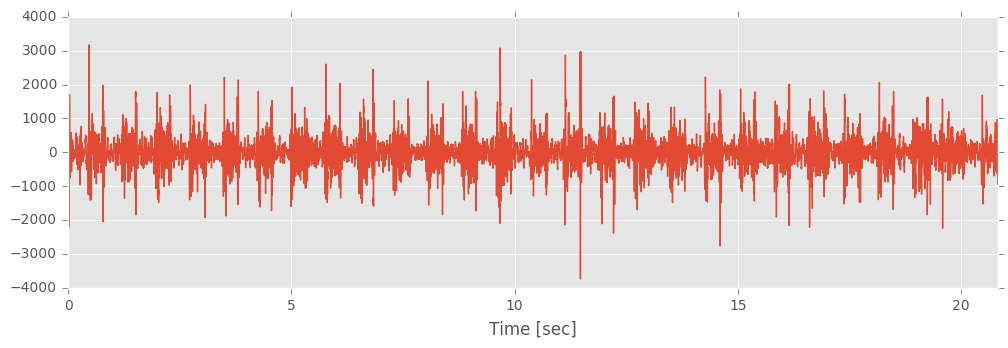

In [104]:
# Plot example sequence

fn = 'data/sequence/validation/full/a0002.npy'

data = np.load(fn)
time = np.arange(data.shape[0]) / 2000
plt.plot(time, data)
plt.xlim([0, time[-1]])
plt.xlabel('Time [sec]')

f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(3.5)

plt.show()

In [5]:
# Generate spectrograms and subspectrograms for all training data
gen_training_spectrograms(training_ddir='data/raw/training/', 
                          out_ddir='data/spectrogram/training/')

# Generate spectrograms and subspectrograms for validation data
gen_spectrograms('data/raw/validation/', 'data/spectrogram/validation/')

/Users/torod/anaconda2/envs/py35/lib/python3.5/site-packages/numpy/lib/shape_base.py:422: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))
/Users/torod/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:7017: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


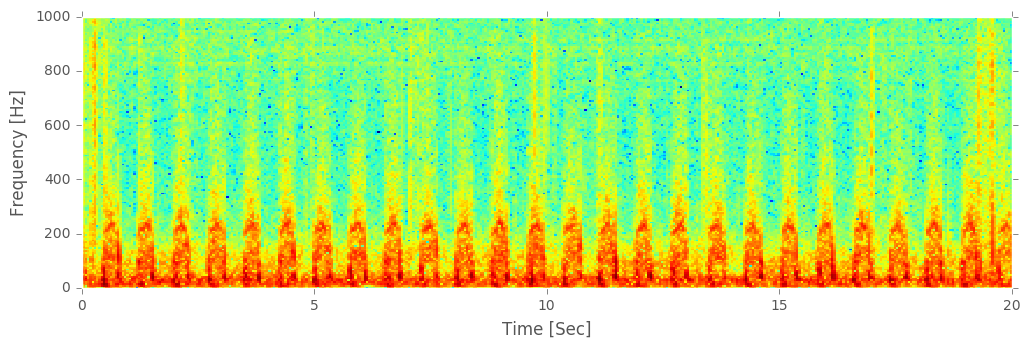

In [111]:
# Plot another example spectrogram

rate, data = wavfile.read("data/raw/validation/a0002.wav")

Pxx, freqs, bins, im = plt.specgram(data, NFFT=300, Fs=rate, 
                                    mode='psd', noverlap=200, scale='dB',
                                    xextent=(0,np.floor(data.shape[0]/rate)))

plt.pcolormesh(bins, freqs, 10*np.log10(Pxx))
plt.xlim((0, np.floor(data.shape[0]/rate)))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [Sec]')

f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(3.5)

plt.show()

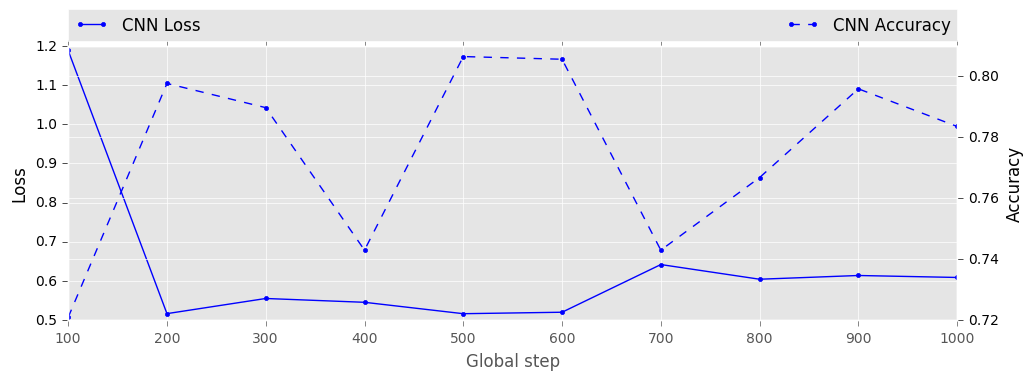

In [112]:
# Plot Loss and Accuracy for CNN

fig, ax1 = plt.subplots()
t = np.arange(100, 1100, 100)

loss = [1.1886137,0.51612258,0.55483007,0.54508698,0.51596189,0.5197084,0.64155644,0.60405266,0.61358339,0.60856622]
CNN_loss, = ax1.plot(t, loss, 'b.-', label='CNN Loss')
ax1.set_xlabel('Global step')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Loss', color='k')
ax1.tick_params('y', colors='k')

accu = [0.72084808,0.79770321,0.78975266,0.74293286,0.80653709,0.80565369,0.74293286,0.76678443,0.79593641,0.78356892]
ax2 = ax1.twinx()
CNN_accu, = ax2.plot(t, accu, 'b.--', label='CNN Accuracy')
ax2.set_ylabel('Accuracy', color='k')
ax2.tick_params('y', colors='k')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., handles=[CNN_loss, CNN_accu])

fig.tight_layout()

f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(3.5)

plt.show()


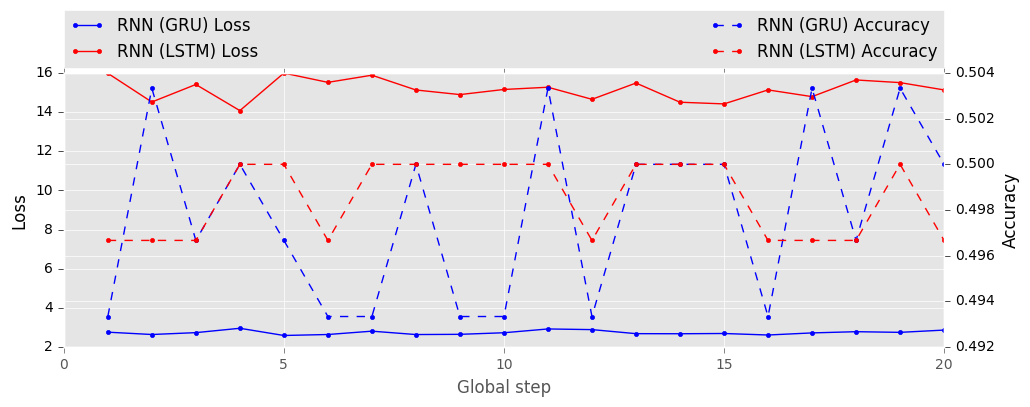

In [113]:
# Plot Loss and Accuracy for RNNs

fig, ax1 = plt.subplots()
t = np.arange(1, 21, 1)

loss_gru = [2.75523257256,2.63591825962,2.73108774424,2.95408129692,2.58588826656,2.6356266737,2.8061375916,2.63370266557,2.64452341199,2.72560831904,2.91945129633,2.88577845693,2.67911812663,2.67435765266,2.68728426099,2.60983964801,2.71713292599,2.77939713001,2.745883286,2.86199635267]
loss_lstm = [15.98592734336853,14.518420219421387,15.414373397827148,14.07909631729126,15.996402025222778,15.522733688354492,15.888619422912598,15.133166313171387,14.897550582885742,15.159421920776367,15.273558616638184,14.656794548034668,15.488088130950928,14.507415294647217,14.421758651733398,15.136865377426147,14.79332423210144,15.644873857498169,15.51005506515503, 15.135666370391846]
RNN_gru_loss, = ax1.plot(t, loss_gru, 'b.-', label='RNN (GRU) Loss')
RNN_lstm_loss, = ax1.plot(t, loss_lstm, 'r.-', label='RNN (LSTM) Loss')
ax1.set_xlabel('Global step')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Loss', color='k')
ax1.tick_params('y', colors='k')

accu_gru = [0.493333,0.503333,0.496667,0.5,0.496667,0.493333,0.493333,0.5,0.493333,0.493333,0.503333,0.493333,0.5,0.5,0.5,0.493333,0.503333,0.496667,0.503333,0.5]
accu_lstm = [0.49666666984558105,0.49666666984558105,0.49666666984558105,0.5,0.5,0.49666666984558105,0.5,0.5,0.5,0.5,0.5,0.49666666984558105,0.5,0.5,0.5,0.49666666984558105,0.49666666984558105,0.49666666984558105,0.5,0.49666666984558105]
ax2 = ax1.twinx()
RNN_gru_accu, = ax2.plot(t, accu_gru, 'b.--', label='RNN (GRU) Accuracy')
RNN_lstm_accu, = ax2.plot(t, accu_lstm, 'r.--', label='RNN (LSTM) Accuracy')
ax2.set_ylabel('Accuracy', color='k')
ax2.tick_params('y', colors='k')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., handles=[RNN_gru_loss, RNN_lstm_loss, RNN_gru_accu, RNN_lstm_accu])

fig.tight_layout()

f = plt.gcf()
f.set_figwidth(12)
f.set_figheight(3.5)

plt.show()